The purpose of this notebook is to evaluate the electron and photon IDs and determine the best way to handle potential overlaps. It borrows from some of the nice efficiency studies from Maria in the lj_reco_efficiency directory.

Logistics:

Need to study 2mu2e sample; copied part of Dongyub's yaml to this branch
For now, just studying the effects with the normal loose electron ID, not the loose ID minus n missing hits
Defined five new cuts, keeping all events but varying the photon ID definition:
- Loose photons
- Loose photons that also pass the electron conversion veto
- Loose photons that also pass the electron conversion veto or are far away from electrons
- Loose photons that also pass the pixel seed veto
- Loose photons that also pass the pixel seed veto or are far away from electrons

Current step: Check effect on efficiency (and invariant mass?) plots

In [1]:
# python
import sys
import os
import importlib
import numpy as np
# columnar analysis
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
# local
sys.path.insert(1, os.path.join(sys.path[0], '../../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
from matplotlib.artist import Artist 
utilities.set_plot_style()
%matplotlib inline

In [2]:
samples = [
    '2mu2e_500GeV_5GeV_0p08mm',
    '2mu2e_500GeV_5GeV_0p8mm',
    '2mu2e_500GeV_5GeV_8p0mm',
    '2mu2e_500GeV_5GeV_40p0mm',
    '2mu2e_500GeV_5GeV_80p0mm'    
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2_merged")

runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    # maxchunks=1,
)

p = sidm_processor.SidmProcessor(
    [
        "AllEvts_ElectronVetoPhotons", "AllEvts_ElectronVetoPhotonsOrIsoPhotons", 
        "AllEvts_PixelSeedPhotons", "AllEvts_PixelSeedPhotonsOrIsoPhotons",
        "AllEvts_AllLoosePhotons"
    ],
    ["gen_base"],
    lj_reco_choices=["0.4"],
    llpnanoaod=True,
    verbose=False,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]['2mu2e_500GeV_5GeV_0p08mm']

Output()

Output()

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered 
in divide
  result = getattr(ufunc, method)(

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in
divide
  result = getattr(ufunc, method)(

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

# Definitions

In [19]:
def plotHists(nums, denoms, channels, errorBars=True, sample=samples[3], upperlim=-1):
    if len(nums) != len(denoms):
        print("Need an even number of numerator and denominator histograms!")
        return
    
    ncol = 2
    nrow = 2
    
    NumUniquePlots = len(nums)*len(channels)
    
    
    if (NumUniquePlots%2) == 0:
        nrow = NumUniquePlots
    else:
        nrow = NumUniquePlots+1
        
    print(nrow, ncol)
    
    fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*15, nrow*9))
    axs_flat = axs.flatten()
    plt.tight_layout()
    
    print(type(axs[0]))
    
    subplotidx = 0
    
    for i, num in enumerate(nums): 
        denom = denoms[i]
        
        for channel in channels:
            #trying to figure out how to "zoom in" the graph's dimensions by using (:40j, :), fix syntax for upperlim==-1
    
            if upperlim==-1
            num_hist =  out["hists"][num][channel]
            else 
            num_hist = out["hists"][num][channel, 400j]
            denom_hist =  out["hists"][denom][channel,:400j]

            # Calculate the efficiency and associated errors
            eff_hist, errors = utilities.get_eff_hist(num_hist, denom_hist)
    
            num_hist.plot1d(ax=axs_flat[subplotidx],label=num)
            denom_hist.plot1d(ax=axs_flat[subplotidx],label=denom)
            axs_flat[subplotidx].set_title(channel)
            axs_flat[subplotidx].set_ylabel("Number of Events")
            axs_flat[subplotidx+2].set_title("Effiency for "+ channel)
            #add a list: ch_titles = ["Pixel Seed..."] abover for loop and include all the different channels in order
            #for subplots, use axs_flat.. to add a legend using the labels found above
            axs_flat[subplotidx].legend()
            eff_hist.plot1d(ax=axs_flat[subplotidx+2],yerr=errors)
            #axs_flat[subplotidx+2].legend()
            axs_flat[subplotidx+2].set_ylabel("Effiency")
            subplotidx = subplotidx+1
            if (subplotidx %2)==0:
                subplotidx = subplotidx+2

SyntaxError: invalid syntax (3375504351.py, line 32)

In [26]:
def plotStackedHists(nums, denom, channels, errorBars=True, sample=samples[4]):
    out = output["out"][sample]
    ncol = 1
    nrow = 2
       
    fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*20, nrow*10))
    plt.tight_layout()
    axs_flat = axs.flatten()
            
    for i, num in enumerate(nums): 
        denom_hist =  out["hists"][denom][channels[0],:]
        denom_hist.plot1d(ax=axs_flat[0],label=denom)
        
        for channel in channels:
            num_hist =  out["hists"][num][channel,:]

            # Calculate the efficiency and associated errors
            eff_hist, errors = utilities.get_eff_hist(num_hist, denom_hist)
    
            num_hist.plot1d(ax=axs_flat[0],label=channel)
            axs_flat[0].set_title(denom)
            axs_flat[0].set_ylabel("Number of Events")
            axs_flat[1].set_ylabel("Effiency")
            
        
            
            #add a title for specific plots, maybe sample name
            #add a ylabel to the plots 
            axs_flat[1].set_title(channel)
            eff_hist.plot1d(ax=axs_flat[1],yerr=errors, label=channel)
    axs_flat[1].legend()
    axs_flat[0].legend()

# Dark Photon Pt/Dark Photon Lxy

Text(0, 1, 'Number of Events')

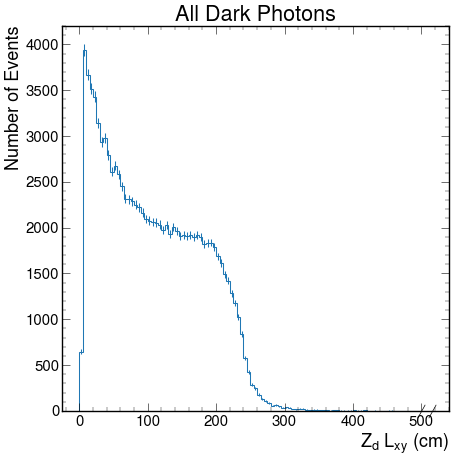

In [5]:
out["hists"]["genAs_toE_lxy"]["AllEvts_AllLoosePhotons",:].plot()
plt.title('All Dark Photons')
plt.ylabel('Number of Events')

We are going to use this plot to compare the other profiles of the different channels using sample [3] (Pt/Lxy)

10 2
<class 'numpy.ndarray'>


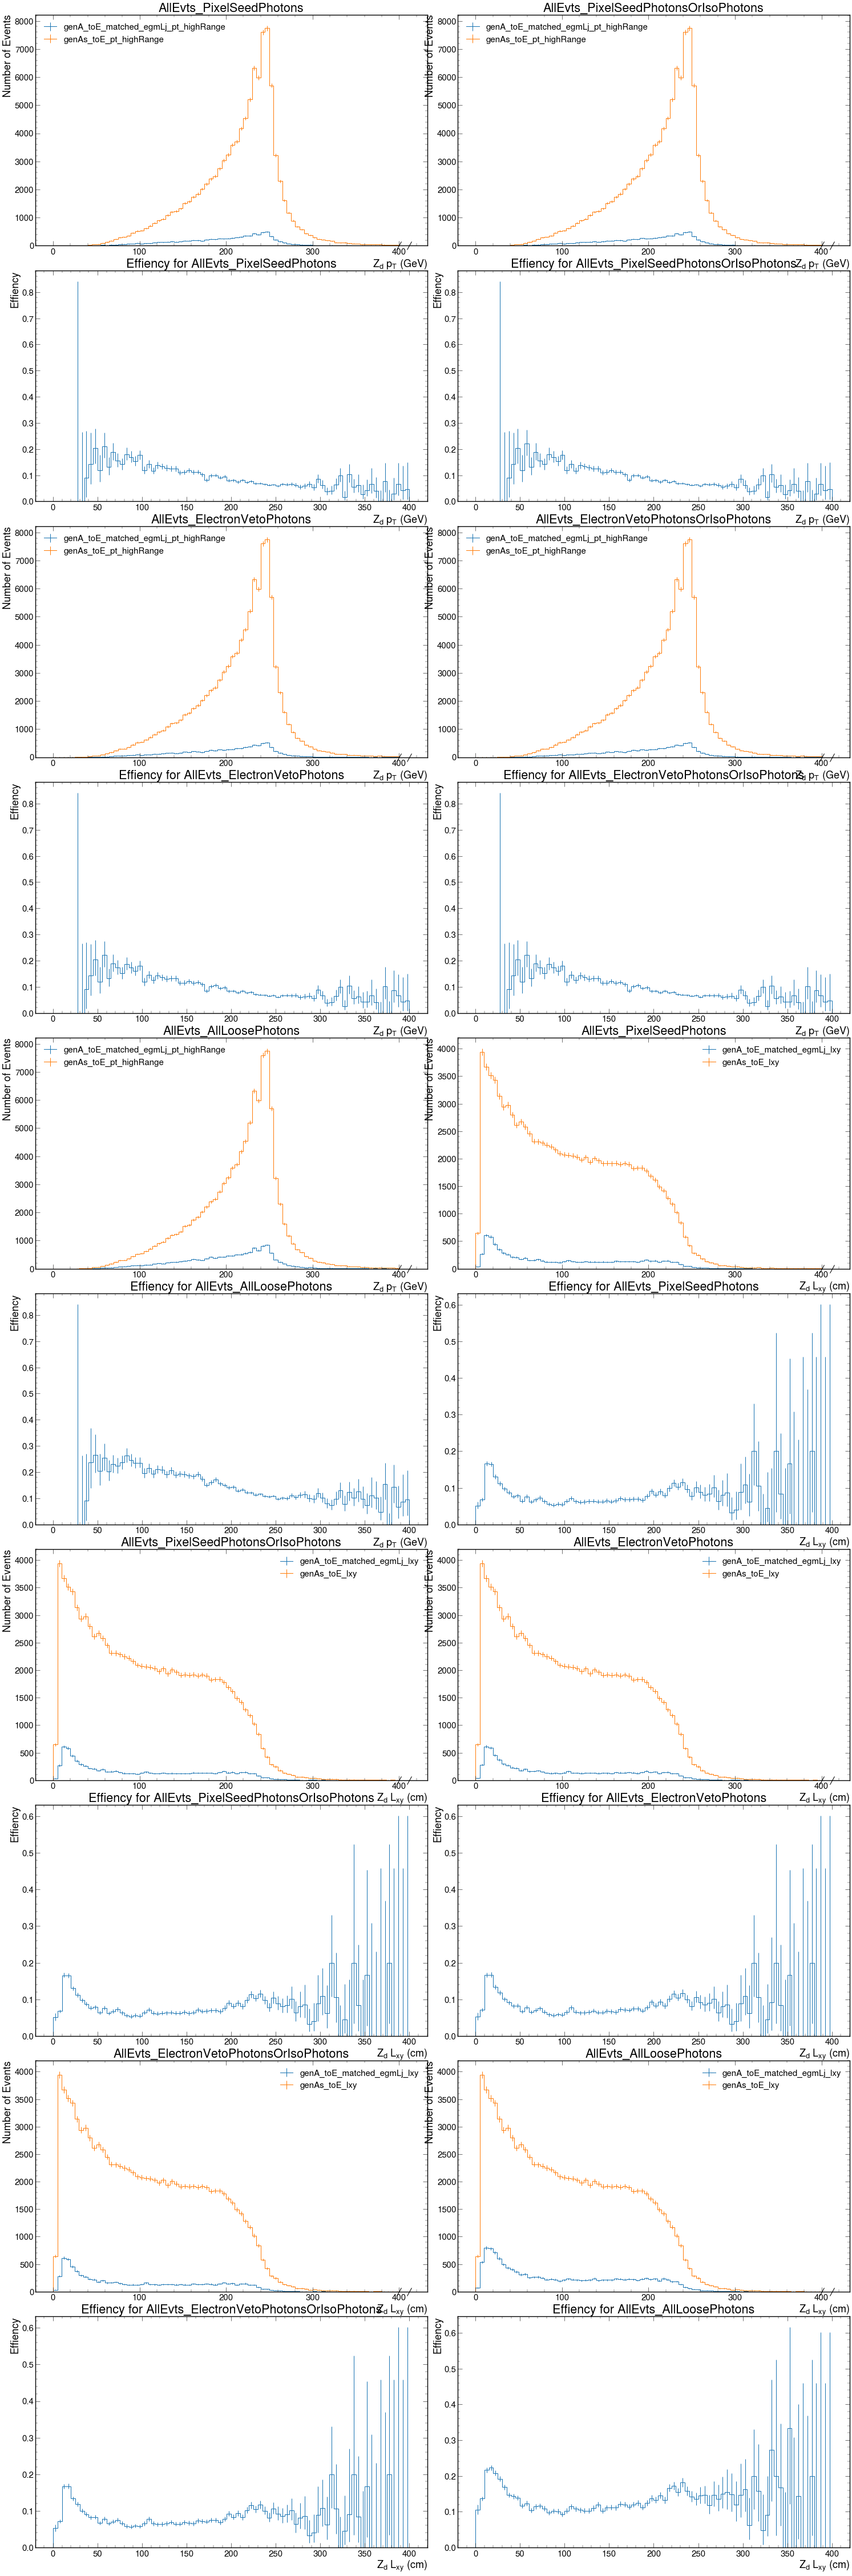

In [18]:
plotHists(["genA_toE_matched_egmLj_pt_highRange","genA_toE_matched_egmLj_lxy"], ["genAs_toE_pt_highRange","genAs_toE_lxy"], 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"], sample = samples[3])

/home/cms-jovyan/SIDM/sidm/studies/egamma_studies/../../../sidm/tools/utilities.py:122: RuntimeWarning: invalid value encountered in divide
  eff_values = num_vals/denom_vals
/home/cms-jovyan/SIDM/sidm/studies/egamma_studies/../../../sidm/tools/utilities.py:122: RuntimeWarning: invalid value encountered in divide
  eff_values = num_vals/denom_vals
/home/cms-jovyan/SIDM/sidm/studies/egamma_studies/../../../sidm/tools/utilities.py:122: RuntimeWarning: invalid value encountered in divide
  eff_values = num_vals/denom_vals
/home/cms-jovyan/SIDM/sidm/studies/egamma_studies/../../../sidm/tools/utilities.py:122: RuntimeWarning: invalid value encountered in divide
  eff_values = num_vals/denom_vals
/home/cms-jovyan/SIDM/sidm/studies/egamma_studies/../../../sidm/tools/utilities.py:122: RuntimeWarning: invalid value encountered in divide
  eff_values = num_vals/denom_vals


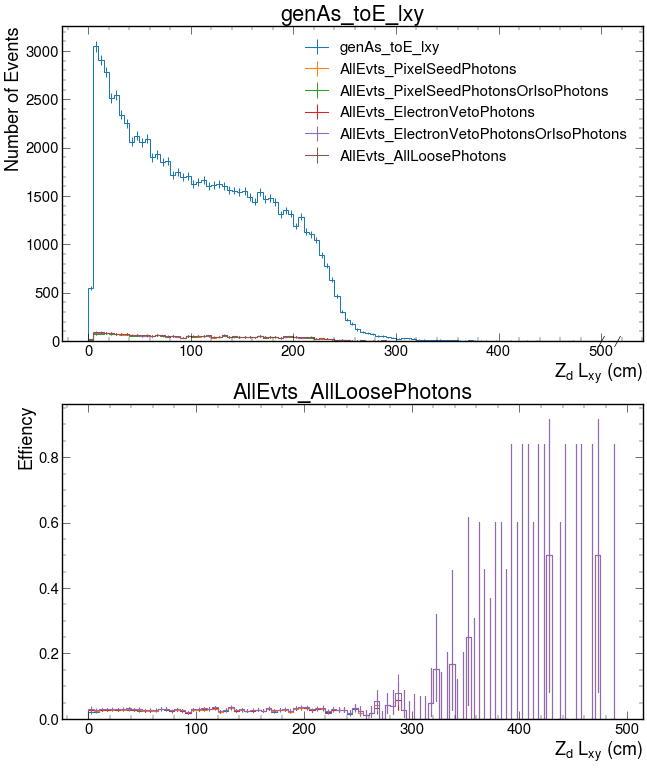

In [32]:
plotStackedHists(["genA_toE_matched_egmLj_lxy"], "genAs_toE_lxy", 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"])
#make a title for the stacked plots

# Stacked Histograms of High Range pt
Matched Dark Photons against ...

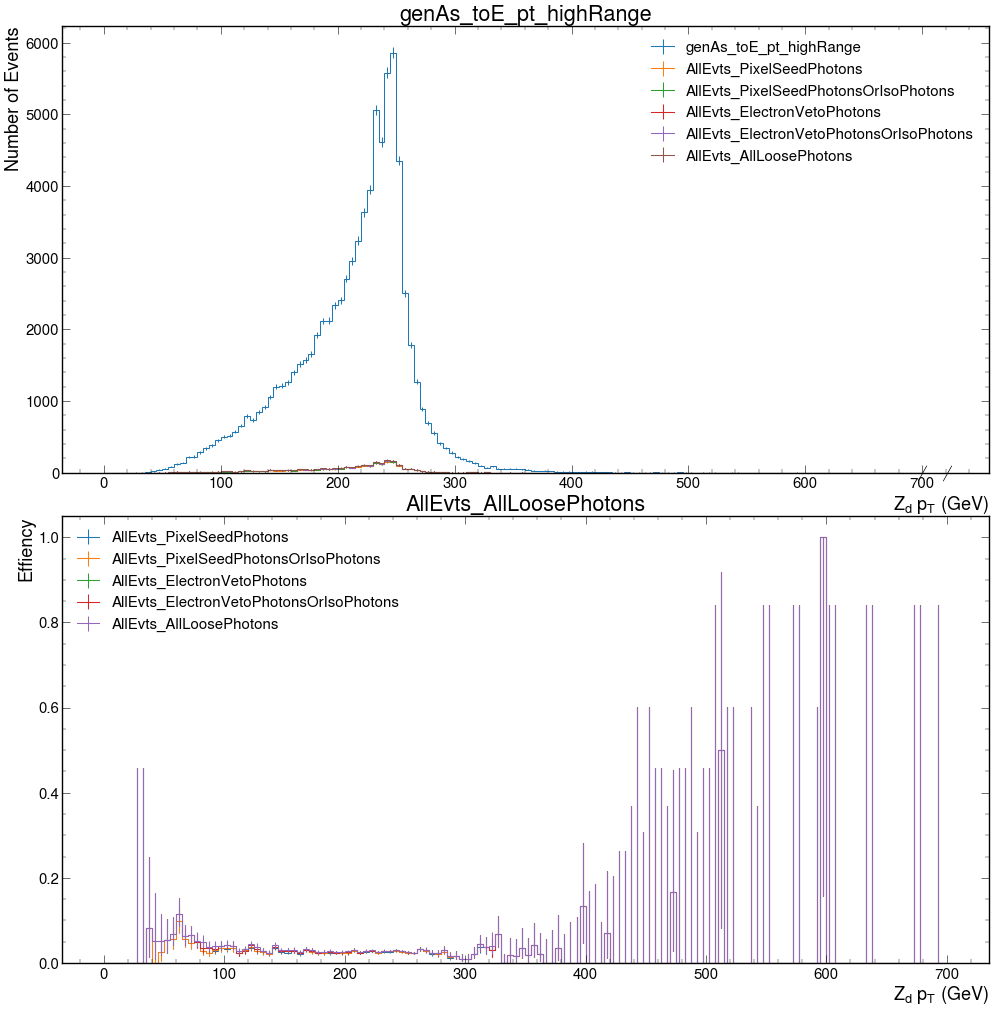

In [27]:
plotStackedHists(["genA_toE_matched_egmLj_pt_highRange"], "genAs_toE_pt_highRange", 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"])

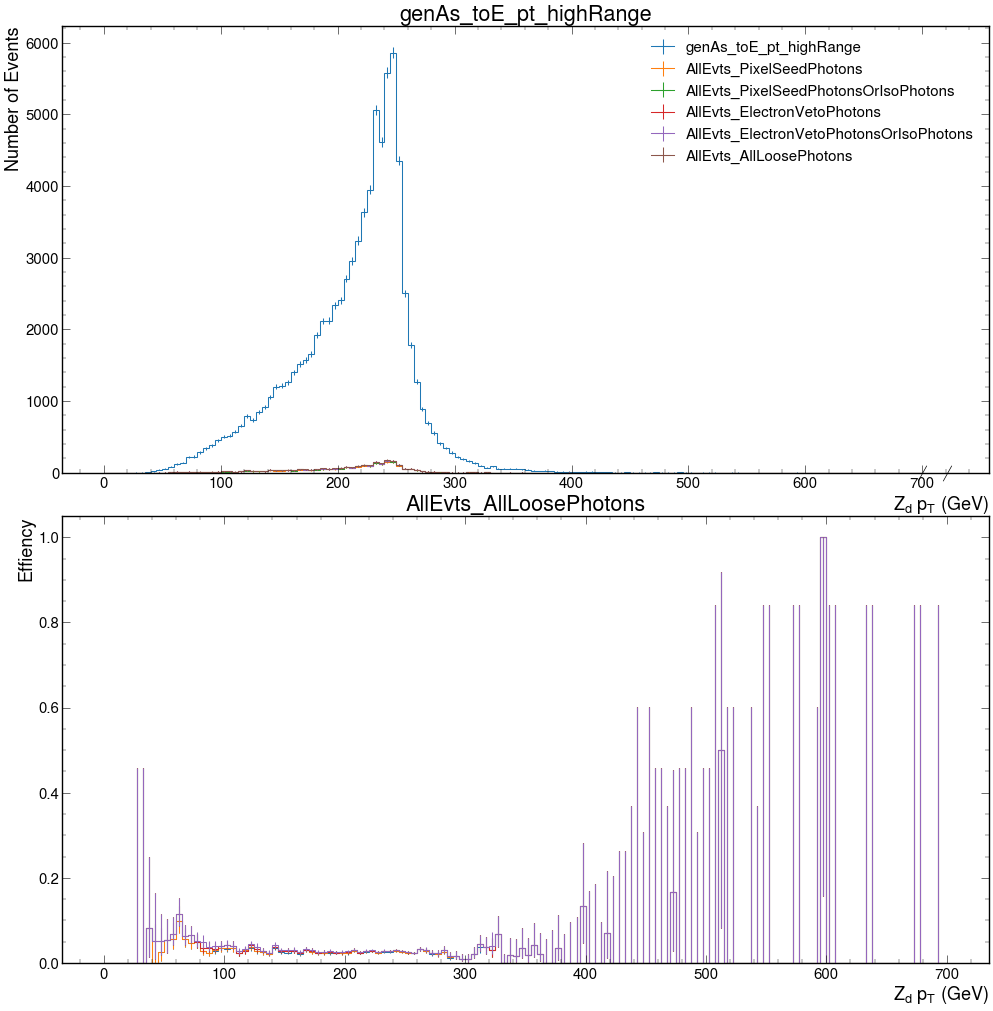

In [8]:
plotStackedHists(["genA_toE_matched_egmLj_pt_highRange"], "genAs_toE_pt_highRange", 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"])